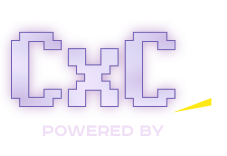
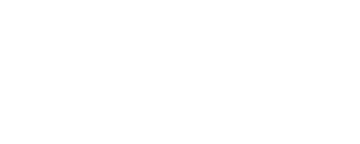

# Infinite Investment Systems Challenge

### The Challenge

The challenge involves analyzing a comprehensive dataset on customer behavior within the wealth management services domain. The dataset, consisting of many columns, aggregates information from various tables, offering insights into customer interactions, financial transactions, trading activities, and overall financial behaviors.

The primary focus is on predicting customer churn and estimating lifetime value.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Projects/history.csv")

Mounted at /content/drive


<ipython-input-2-01b20a2dda0c>:3: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Projects/history.csv")


In [ ]:
# use a `LabelEncoder` to convert "Churn" to `0` and "No Churn" to `1`.

# Assuming 'df' contains your target variable with string labels
label_encoder = LabelEncoder()

# Fit and transform the 'size_class' column
df['label'] = label_encoder.fit_transform(df['label'])

# Set test set to label
y = df["label"]

In [ ]:
# Finding columns with high frequency of missing data
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Identify columns with more than 60% missing values
columns_with_lots_of_missing_data = missing_percentage[missing_percentage > 60].index.tolist()

# Display these columns
print(columns_with_lots_of_missing_data)
print(len(columns_with_lots_of_missing_data))

# Drop these columns from the dataset (over 60% missing)
df.drop(columns_with_lots_of_missing_data, axis=1, inplace=True)

# Drop Uneeded columns
columns_to_drop = ['inserted_at', 'updated_at', 'is_olob', 'retail_last_maintenance_time', 'retail_last_maintenance_user', 'visible_in_reports', 'currency_code', 'iso_funds_code', 'title', 'non_calendar_year_end']
df.drop(columns_to_drop, axis=1, inplace=True)

['country_code', 'cashflows_custody_fee', 'arp_pension_origin', 'sss_location', 'sss_type', 'sss_agent', 'target_grantor_grantee_flag', 'esir_number', 'shareholder_language', 'special_tag', 'conjunction', 'function_code', 'tms_settlement_location', 'loan_limit_override', 'special_fee_code', 'plan_end_date', 'resp_specimen_plan']
17


In [ ]:
# Creating a hash map to encode 'debit_code'
mapping = {
    '0': 0,
    'A': 1,
    'C': 2,
    'T': 3
}
df['debit_code'] = df['debit_code'].map(mapping)

In [ ]:
# one-hot enconding specific data Retail plan (only 9 colums)
# Perform one-hot encoding on the 'retail_plan' column and update df
df = pd.get_dummies(df, columns=['retail_plan'])

# Display the first few rows of the updated DataFrame to verify the changes
# print(df.head())

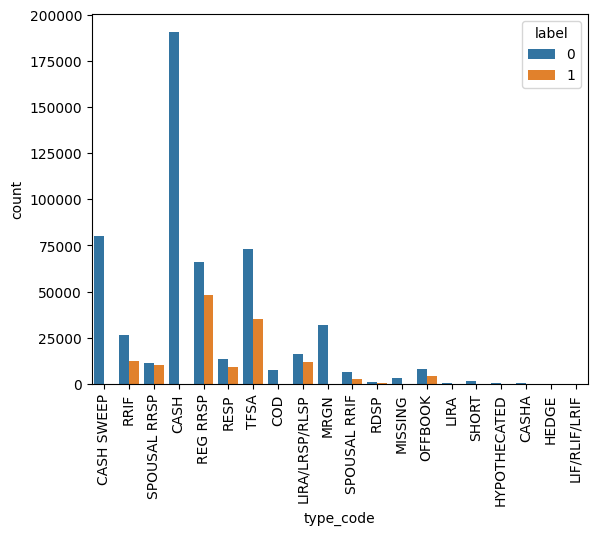

['CASH', 'CASH SWEEP', 'CASHA', 'COD', 'HEDGE', 'HYPOTHECATED', 'MISSING', 'MRGN', 'RDSP', 'SHORT']


In [ ]:
# Performing Exploratory Analysis on Categorical Data

# For each categorical variable, you can plot its relationship with churn
sns.countplot(x='type_code', hue='label', data=df)
plt.xticks(rotation=90)
plt.show()

grouped = df.groupby(['type_code', 'label']).size().reset_index(name='count')
pivot_table = grouped.pivot(index='type_code', columns='label', values='count').fillna(0)
filtered = pivot_table[pivot_table[0] > 3 * pivot_table[1]]
print(filtered.index.tolist())

# type_code has a strong correllation with churn, for example, a customer with an account below has >75% of churn
# ['CASH', 'CASH SWEEP', 'CASHA', 'COD', 'HEDGE', 'HYPOTHECATED', 'MISSING', 'MRGN', 'RDSP', 'SHORT']

# Using target encoding to encode the category:
mean_encode = df.groupby('type_code')['label'].mean()
df['type_code'] = df['type_code'].map(mean_encode)


In [ ]:
# converting values with 't' and 'f' into numbers

# convert_values() converts all 't' or 'f' values within the DataFrame into 1's and 0's
def convert_values(cell):
    if cell == 't':
        return 1
    elif cell == 'f':
        return 0
    else:
        return cell  # Keeps the original value if it's not 't' or 'f'

# Apply the conversion to the entire DataFrame
df = df.applymap(convert_values)

In [ ]:
# drop ID, drop label
df.drop(columns="label", axis=1, inplace=True)
df.drop(columns="id", axis=1, inplace=True)

### Excluding Remaining Non-Numerical Data


In [ ]:
# Create a copy of 'df'
X = df.copy()
# Now 'X' is an independent copy of 'df'

# Identify numeric columns
numeric_columns = [
    col for col in X.columns
    if X[col].dtype in ["float64", "int64"]
]

# Specify the features without categorical columns
X = X[numeric_columns]

# Count the number of missing values in each column
missing_values_count = X.isnull().sum()

# Display the counts
print("Number of missing values in each column:")
print(missing_values_count)

Number of missing values in each column:
type_code          237
is_registered        0
is_active            0
class_id          3198
debit_code        4317
                  ... 
retail_plan_QS       0
retail_plan_RD       0
retail_plan_RI       0
retail_plan_RS       0
retail_plan_TF       0
Length: 70, dtype: int64


### Filling Missing Value


In [ ]:
# Using median to imputate missing values
median_value = X.median()
median_imputation = X.fillna(median_value)
median_imputation.head()

# Count the number of missing values in each column
missing_values_count = median_imputation.isnull().sum()

# Display the counts, make sure changes occured
print("Number of missing values in each column:")
print(missing_values_count)



Number of missing values in each column:
type_code         0
is_registered     0
is_active         0
class_id          0
debit_code        0
                 ..
retail_plan_QS    0
retail_plan_RD    0
retail_plan_RI    0
retail_plan_RS    0
retail_plan_TF    0
Length: 70, dtype: int64


#### Train-Test Split
The training set is split into subsets for training and testing, commonly referred to as the validation set. This enables us to evaluate the model's performance before applying it to the actual test set.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(median_imputation, y, test_size=0.2, random_state=42)

### Training the model
We used xgboost and RandomizedSearch for a fast and effective way to tune hyper
paramaters

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
}

# Initialize the XGBoost Classifier

xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_classifier, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)

# Fit it to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_estimator = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.7468055921327309, 'learning_rate': 0.041198904067240534, 'max_depth': 5, 'n_estimators': 137, 'subsample': 0.8001125833417065}
Best score: 0.9656413655088171


#### Evaluating our model
Using f1, mcc, and cv scores


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_val_score

# Predict on the validation set
y_pred = best_estimator.predict(X_val)

# Calculate the F1 score
f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1}")

# Calculate the MCC score
mcc_score = matthews_corrcoef(y_val, y_pred)
print(f"MCC Score: {mcc_score}")


cv_scores = cross_val_score(best_estimator, X=X_train, y=y_train, cv=5)
print(f"Average CV Score: {sum(cv_scores)/len(cv_scores)}")

F1 Score: 0.9242610837438423
MCC Score: 0.9070376440751509
Average CV Score: 0.9656395097286417


# Feature Analysis


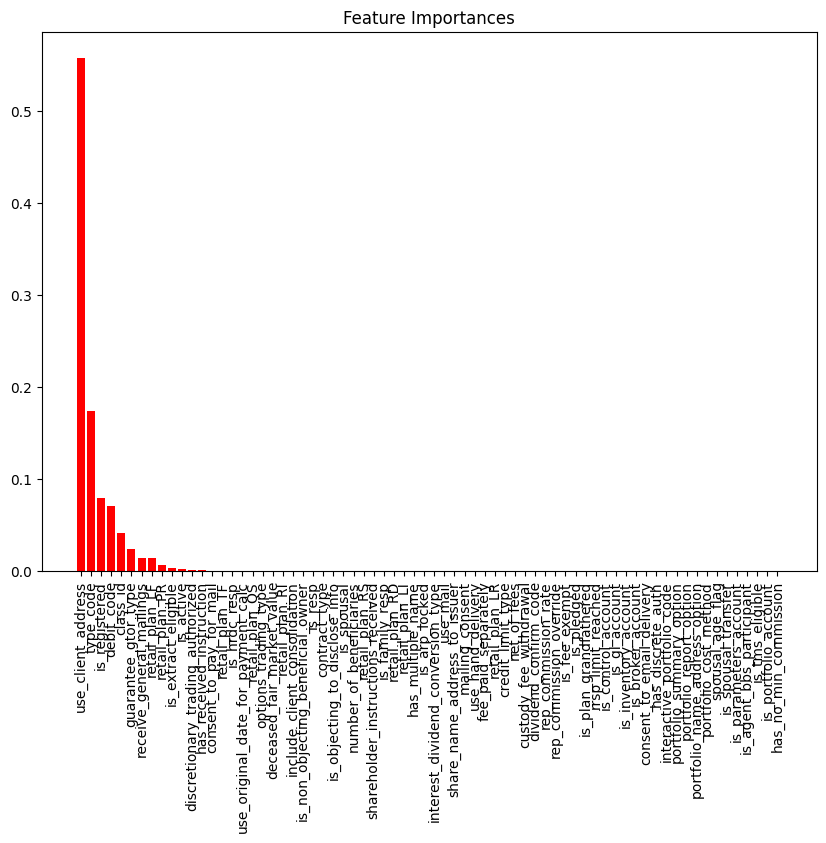

In [ ]:
# we wish to identify a small number of features that most strongly predict whether an individual will churn
# using matplotlib.pyplot we can interpret this graphically
# The `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier

# Extracting feature names and their importance scores
feature_names = X_train.columns
importances = best_estimator.feature_importances_

indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 7))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.show()

# We know now our model is heavily dependent on only a couple features
# we could significantly increase the performance and training-time of the model
# by using a training set with the top 5 most important features, this would
# likely reduce the scores of our model minimally. Since we are focused on getting
# the highest score possible we have decided to not implement this.

# Submission
This marks the end of this guide. For this challenge you'll need to use your trained model to make predictions on which of the current selection of clients is likely or not to churn. The list of those clients can be found in the `test.csv` dataset.

Run inference on this list and save the inference results as a CSV file. The file should adhere to the following format:

```csv
id, predicted
1155742, No Churn
1269359, Churn
595581, Churn
3866311, No Churn
....
```

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Projects/test.csv')
features = median_imputation.columns.tolist()

# Save ID columm it will be removed in next step
id_column = test_df['id'].copy()

<ipython-input-26-f9337e15ccd7>:1: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('/content/drive/MyDrive/Projects/test.csv')


In [ ]:
# Preprocess test data

test_df = pd.get_dummies(test_df, columns=['retail_plan'])     # One-hot encoding

# Drop all non-training columns
test_df = test_df[features]

# Deal with categorical Data
test_df['debit_code'] = test_df['debit_code'].map(mapping)     # Debit code hash-map
test_df = test_df.applymap(convert_values)                     # Converting T & F
test_df['type_code'] = test_df['type_code'].map(mean_encode)   # Normalizing type_code

# Impute the test data using median values from training data
X_test = test_df.fillna(median_value)
non_numeric_cols = X_test.select_dtypes(include='object').columns.tolist()

X_test['portfolio_name_address_option'] = X_test['portfolio_name_address_option'].astype('category')
X_test['portfolio_summary_option'] = X_test['portfolio_summary_option'].astype('category')

<ipython-input-27-40e4d67c13c2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['debit_code'] = test_df['debit_code'].map(mapping)     # Debit code hash-map


In [ ]:
# Get the probability predictions
y_prob = best_estimator.predict_proba(X_test)[:, 1]
y_pred = ["No Churn" if prob > 0.5 else "Churn" for prob in y_prob]

submission_df = pd.DataFrame({
    'id': id_column,
    'predicted': y_pred
})

In [ ]:
submission_df

,id,predicted
0,1155742,Churn
1,1269359,Churn
2,573181,Churn
3,967968,No Churn
4,595581,Churn
...,...,...
168330,1047726,Churn
168331,888353,Churn
168332,1090674,Churn
168333,1034923,No Churn


In [ ]:
submission_df.to_csv('/content/drive/MyDrive/Projects/submission.csv', index=False)